<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install tensorflow
!pip install moviepy

zsh:1: no matches found: gym[classic_control]
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


### <font color='blue'> for mac !pip install tensorflow-macos <font>

## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

In [4]:
help(env)

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(env: gym.core.Env, max_episode_steps: Optional[int] = None)
 |  
 |  This wrapper will issue a `truncated` signal if a maximum number of timesteps is exceeded.
 |  
 |  If a truncation is not defined inside the environment itself, this is the only place that the truncation signal is issued.
 |  Critically, this is different from the `terminated` signal that originates from the underlying environment as part of the MDP.
 |  
 |  Example:
 |     >>> from gym.envs.classic_control import CartPoleEnv
 |     >>> from gym.wrappers import TimeLimit
 |     >>> env = CartPoleEnv()
 |     >>> env = TimeLimit(env, max_episode_steps=1000)
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: gym.core.Env, max_episode_steps: Optional[int] = Non

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:
observation = env.reset()

print("Initial observations:", observation)

Initial observations: (array([-0.000837  ,  0.02186422,  0.02738832,  0.01808334], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

The **episode ends** if any one of the following occurs:<br>
**Termination**: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display) <br>
**Termination**: Pole Angle is greater than ±12° (±0.20944 rad)<br>
**Truncation**: Episode length is greater than 500.


In [8]:
# step(x): Choose an action (0 or 1)
observation, reward, terminated, truncated, info = env.step(1)

# Observation: Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip
print("New observations after choosing action 0:", observation)

# Reward: 1 for every step taken, including the termination step
print("Reward for this step:", reward)

# Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
# Termination: Pole Angle is greater than ±12° (±0.20944 rad)
print("Is this round terminated?", terminated)

# Truncation: Episode length is greater than 500
print("Is this round truncated?", truncated)

New observations after choosing action 0: [-0.00039972  0.21658291  0.02774999 -0.26583397]
Reward for this step: 1.0
Is this round terminated? False
Is this round truncated? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
truncated = terminated = False

# Putting trunctated only will result in a 500 episode lenth before it terminates
print("\t\t\t\t\tCart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip")

while not (truncated or terminated):
    observation, reward, terminated,truncated, info = env.step(0)
    print(f"New observations after choosing action {int(cumulative_reward)}:", observation)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)
print("Is this round terminated?", terminated)
print("Is this round truncated?", truncated)

					Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip
New observations after choosing action 0: [-0.01450467 -0.18527532  0.00362271  0.31337625]
New observations after choosing action 1: [-0.01821018 -0.38044867  0.00989023  0.60719943]
New observations after choosing action 2: [-0.02581915 -0.5757075   0.02203422  0.90298104]
New observations after choosing action 3: [-0.03733331 -0.7711209   0.04009384  1.2025075 ]
New observations after choosing action 4: [-0.05275572 -0.9667377   0.06414399  1.5074813 ]
New observations after choosing action 5: [-0.07209048 -1.1625761   0.09429362  1.8194802 ]
New observations after choosing action 6: [-0.095342   -1.3586111   0.13068323  2.1399076 ]
New observations after choosing action 7: [-0.12251422 -1.55476     0.17348137  2.469934  ]
New observations after choosing action 8: [-0.15360942 -1.7508655   0.22288005  2.8104248 ]
Cumulative reward for this round: 9.0
Is this round terminated? True
Is this round truncated? False


# Sample Codes

## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [10]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [11]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: (array([-0.04824653,  0.01533898,  0.03822736, -0.00569103], dtype=float32), {})
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

[205 210 180 200 224 166 150 200 224 207 152 154 164 201 213 218 204 187
 249 180 228 232 159 183 244 198 187 202 218 154 230 216 177 197 223 228
 215 249 207 186 150 249 191 214 222 223 219 221 232 210 229 204 237 241
 192 155 238 205 195 224 171 163 246 226 189 157 195 219 208 155 235 191
 235 151 214 229 154 173 246 183 234 246 154 167 216 178 154 189 176 172
 170 209 185 249 232 186 196 178 201 225]


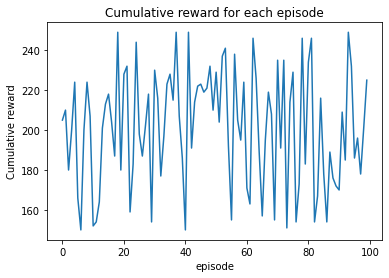

In [12]:
episode_results = np.random.randint(150, 250, size=100)
print(episode_results)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [13]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 201.29
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [14]:
env = RecordVideo(gym.make("CartPole-v1",render_mode = "human"),"./video")

# run for 10 episodes
for episode in range(10):
  observation = env.reset()
  while True:
      env.render()
      #your agent goes here
      action = rand_policy_agent(observation)
      observation, reward, terminated,truncated, info = env.step(action) 
      if terminated: 
        break;    
env.close()
show_video()

Could not find video


# <font color='lightgreen'> Our implementation </font>

## Task 1: Development of an RL agent

Creating a Q table<br>

We also need to define the number of states and actions.

Since the environment is a continuous observation space, we need to convert it into a discete observation space.

We will be converting the continuous state space using the user-defined function Discrete(state,bins)

We will also define Qtable, a funciton to create a Q-Table, it will return a tuple of the with bins of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [40]:
# CART POLE, make the environment
env = gym.make('CartPole-v1')

# Q-Table
def Qtable(state_space,action_space,bin_size = 30):
    # Create bins for each state, corresponding to cart position, velocity and pole angle, angular velocity.
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    # Create Q-Table with all zeros
    q_table = np.zeros(shape=([bin_size] * state_space + [action_space]))
    
    #print(q_table.shape)

    return q_table, bins

q_table , bins = Qtable(len(env.observation_space.low),env.action_space.n)

# Discretize the state
def Discrete(state, bins):
    index = []
    for i in range(len(state)): 
        index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

Definining the Q Learning Agent

In [152]:
def Q_learning(q_table, bins, episodes = 100, gamma = 0.95, lr = 0.1, timestep = 1000, epsilon = 0.2):
    rewards = 0
    solved = False 
    steps = 0 
    runs = [0]
    data = {'max' : [0], 'avg' : [0]}
    start = time.time()
    ep = [i for i in range(0,episodes + 1,timestep)] 
    
    for episode in range(1,episodes+1):
        
        current_state = Discrete(env.reset()[0],bins) # initial observation
        score = 0
        steps = 0 
        terminated = truncated =  False
        temp_start = time.time()
        
        while not (terminated or truncated):

            steps += 1 

            ep_start = time.time()
            if episode%timestep == 0:
                env.render()
                
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])
            
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = Discrete(observation,bins)

            score += reward
            
            if not (terminated or truncated):
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)]
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q

            current_state = next_state
            
        # End of the loop update
        else:
            rewards += score
            runs.append(score)
            print("Episode, Steps, Score, Rewards: {}, {}, {}, {}".format(episode, steps, score, rewards))
            if score > 195 and steps >= 100 and solved == False: # considered as a solved:
                solved = True
                print('Solved in episode : {} in time {}'.format(episode, (time.time()-ep_start)))
            data['avg'].append(rewards)
    '''
        # Timestep value update
        if episode%timestep == 0:
            print('Episode : {} | Reward -> {} | Max reward : {} | Time : {}'.format(episode,rewards/timestep, max(runs), time.time() - ep_start))
            data['max'].append(max(runs))
            data['avg'].append(rewards/timestep)
            if rewards/timestep >= 195: 
                print('Solved in episode : {}'.format(episode))
            rewards, runs = 0, [0]

        # Plotting
        if len(ep) == len(data['max']):
            plt.plot(ep, data['max'], label = 'Max')
            plt.plot(ep, data['avg'], label = 'Avg')
            plt.xlabel('Episode')
            plt.ylabel('Reward')
            plt.legend(loc = "upper left") 
    '''
    return data['avg']
env.close()

For Task 1, we can show the observation and chosen action below:

In [111]:
#Genereate q table with bins
q_table, bins = Qtable((env.observation_space.shape[0]), env.action_space.n)

# Train the agent
Q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 5*10**3, timestep = 1000)

Episode, Steps, Rewards: 1, 9, 9.0
Episode, Steps, Rewards: 2, 26, 26.0
Episode, Steps, Rewards: 3, 36, 36.0
Episode, Steps, Rewards: 4, 45, 45.0
Episode, Steps, Rewards: 5, 55, 55.0
Episode, Steps, Rewards: 6, 66, 66.0
Episode, Steps, Rewards: 7, 77, 77.0
Episode, Steps, Rewards: 8, 92, 92.0
Episode, Steps, Rewards: 9, 102, 102.0
Episode, Steps, Rewards: 10, 118, 118.0
Episode, Steps, Rewards: 11, 135, 135.0
Episode, Steps, Rewards: 12, 148, 148.0
Episode, Steps, Rewards: 13, 158, 158.0
Episode, Steps, Rewards: 14, 170, 170.0
Episode, Steps, Rewards: 15, 181, 181.0
Episode, Steps, Rewards: 16, 191, 191.0
Episode, Steps, Rewards: 17, 202, 202.0
Episode, Steps, Rewards: 18, 216, 216.0
Episode, Steps, Rewards: 19, 229, 229.0
Episode, Steps, Rewards: 20, 255, 255.0
Episode, Steps, Rewards: 21, 266, 266.0
Episode, Steps, Rewards: 22, 281, 281.0
Episode, Steps, Rewards: 23, 294, 294.0
Episode, Steps, Rewards: 24, 303, 303.0
Episode, Steps, Rewards: 25, 313, 313.0
Episode, Steps, Rewards: 26

KeyboardInterrupt: 

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

Episode, Steps, Score, Rewards: 1, 18, 18.0, 18.0
Episode, Steps, Score, Rewards: 2, 10, 10.0, 28.0
Episode, Steps, Score, Rewards: 3, 15, 15.0, 43.0
Episode, Steps, Score, Rewards: 4, 16, 16.0, 59.0
Episode, Steps, Score, Rewards: 5, 9, 9.0, 68.0
Episode, Steps, Score, Rewards: 6, 11, 11.0, 79.0
Episode, Steps, Score, Rewards: 7, 15, 15.0, 94.0
Episode, Steps, Score, Rewards: 8, 15, 15.0, 109.0
Episode, Steps, Score, Rewards: 9, 10, 10.0, 119.0
Episode, Steps, Score, Rewards: 10, 14, 14.0, 133.0
Episode, Steps, Score, Rewards: 11, 10, 10.0, 143.0
Episode, Steps, Score, Rewards: 12, 23, 23.0, 166.0
Episode, Steps, Score, Rewards: 13, 21, 21.0, 187.0
Episode, Steps, Score, Rewards: 14, 23, 23.0, 210.0
Episode, Steps, Score, Rewards: 15, 12, 12.0, 222.0
Episode, Steps, Score, Rewards: 16, 19, 19.0, 241.0
Episode, Steps, Score, Rewards: 17, 11, 11.0, 252.0
Episode, Steps, Score, Rewards: 18, 10, 10.0, 262.0
Episode, Steps, Score, Rewards: 19, 13, 13.0, 275.0
Episode, Steps, Score, Rewards

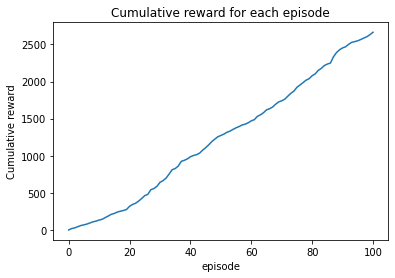

In [153]:
#Genereate q table with bins
q_table, bins = Qtable((env.observation_space.shape[0]), env.action_space.n)

# Train the agent
episode_results = Q_learning(q_table, bins, lr = 0.95, gamma = 0.995, episodes = 100, timestep = 1)
print(episode_results)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [154]:
print("Average cumulative reward:", np.array(episode_results).mean())
print("Is my agent good enough?", np.array(episode_results).mean() > 195)
print(np.array(episode_results).sum()/100)

Average cumulative reward: 1239.7722772277227
Is my agent good enough? True
1252.17


## Task 3: Render one episode played by the agent